In [2]:
import pandas as pd

# Load the provided files
file_path_yield = "C:/Users/a/Desktop/tomato/tlstm/전북군산생산량_변환.csv"
file_path_env = "C:/Users/a/Desktop/tomato/tlstm/전북군산환경데이터_변환.csv"

# Reading the data
yield_data = pd.read_csv(file_path_yield)
env_data = pd.read_csv(file_path_env)

# Display the first few rows of both datasets to understand their structure
yield_data.head(), env_data.head()


(     연도  월    면적  item.frmhsId  생산량  주차
 0  2017  8  2950            25    0  35
 1  2017  9  2950            25    0  36
 2  2017  9  2950            25    0  37
 3  2017  9  2950            25    0  38
 4  2017  9  2950            25    0  39,
      inTp    inHd       measDtStr  otmsuplyqy  acSlrdQy  frmhsId  cunt   ph  \
 0  26.400  90.850  20170801000000         0.0         0       25   0.0  0.0   
 1  26.175  91.375  20170801010000         0.0         0       25   0.0  0.0   
 2  26.225  90.825  20170801020000         0.0         0       25   0.0  0.0   
 3  25.900  92.350  20170801030000         0.0         0       25   0.0  0.0   
 4  25.600  91.875  20170801040000         0.0         0       25   0.0  0.0   
 
     outTp  outWs  daysuplyqy   inCo2   ec  
 0  24.350    0.0           0  463.00  0.0  
 1  24.175    0.0           0  472.75  0.0  
 2  24.100    0.0           0  477.75  0.0  
 3  23.900    0.0           0  486.25  0.0  
 4  23.650    0.0           0  490.50  0.0  )

In [3]:
# 날짜 데이터를 datetime 형식으로 변환하고 연도, 월, 주차 정보를 추출
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')

# 연도, 월, 주차 정보 추출
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['월'] = env_data['measDtStr'].dt.month
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 생산량 데이터와 환경 데이터를 연도, 월, 주차 기준으로 병합
merged_data = pd.merge(yield_data, env_data[['연도', '월', '주차', 'inTp', 'inHd', 'outTp', 'inCo2']], on=['연도', '월', '주차'], how='inner')

# 병합된 데이터 확인 (상위 5개 행 출력)
print(merged_data.head())


     연도  월    면적  item.frmhsId  생산량  주차    inTp    inHd   outTp  inCo2
0  2017  8  2950            25    0  35  23.200  80.675  20.775  469.0
1  2017  8  2950            25    0  35  22.950  81.450  19.900  486.0
2  2017  8  2950            25    0  35  22.925  81.750  19.750  505.0
3  2017  8  2950            25    0  35  22.700  82.475  19.500  518.5
4  2017  8  2950            25    0  35  22.525  81.275  19.150  529.0


In [4]:
# Drop the 'item.frmhsId' column from the merged dataset
merged_data = merged_data.drop(columns=['item.frmhsId'])

# Display the first few rows of the updated dataset to confirm
merged_data.head()


,연도,월,면적,생산량,주차,inTp,inHd,outTp,inCo2
0,2017,8,2950,0,35,23.200,80.675,20.775,469.0
1,2017,8,2950,0,35,22.950,81.450,19.900,486.0
2,2017,8,2950,0,35,22.925,81.750,19.750,505.0
3,2017,8,2950,0,35,22.700,82.475,19.500,518.5
4,2017,8,2950,0,35,22.525,81.275,19.150,529.0


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 데이터 로드 및 전처리는 앞서 설명한 방식으로 수행
# shifted_data에 시차 적용 완료된 데이터가 있다고 가정

# Apply a time shift (90 days = 12 weeks) for the yield column
shifted_data = merged_data.copy()
shifted_data['생산량'] = shifted_data['생산량'].shift(-12)  # Shift the yield column by 12 weeks
shifted_data = shifted_data.dropna()  # Remove rows with NaN values caused by the shift

# Split features (X) and target (y)
X = shifted_data[['면적', 'inTp', 'inHd', 'outTp', 'inCo2']].values
y = shifted_data['생산량'].values

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input to 3D [samples, timesteps, features] for LSTM
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the LSTM model with additional layers and dropout
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with more epochs and early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)

# Print the test loss
print(f"Test Loss: {test_loss}")


Epoch 1/50


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 41487428.0000 - val_loss: 36836292.0000
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33283046.0000 - val_loss: 20698370.0000
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18952934.0000 - val_loss: 16552625.0000
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16714756.0000 - val_loss: 15589454.0000
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15649456.0000 - val_loss: 14987145.0000
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15125902.0000 - val_loss: 14518505.0000
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15022445.0000 - val_loss: 14164677.0000
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14130289.0000 - val_loss: 13883200.0000
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13683950.0000 - val_loss: 13648831.0000
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13718033.0000 - val_loss: 13453698.0000
Epoch 11/5

In [6]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 데이터 로드 및 전처리는 기존 방식과 동일합니다.
# shifted_data에 시차 적용 완료된 데이터가 있다고 가정

# Apply a time shift (90 days = 12 weeks) for the yield column
shifted_data = merged_data.copy()
shifted_data['생산량'] = shifted_data['생산량'].shift(-12)  # Shift the yield column by 12 weeks
shifted_data = shifted_data.dropna()  # Remove rows with NaN values caused by the shift

# Split features (X) and target (y)
X = shifted_data[['면적', 'inTp', 'inHd', 'outTp', 'inCo2']].values
y = shifted_data['생산량'].values

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타임 스텝을 4주로 설정 (4주치의 데이터를 하나의 입력으로 사용)
timesteps = 4
X_sequences = []
y_sequences = []

# 타임 스텝을 적용해 X와 y를 구성
for i in range(len(X_scaled) - timesteps):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y[i+timesteps])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with more epochs and early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)

# Print the test loss
print(f"Test Loss: {test_loss}")


Epoch 1/50


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 32095742.0000 - val_loss: 14394718.0000
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13807882.0000 - val_loss: 12828350.0000
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13105858.0000 - val_loss: 12440520.0000
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12712730.0000 - val_loss: 12055653.0000
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12615206.0000 - val_loss: 11897438.0000
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12300988.0000 - val_loss: 11945510.0000
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12205539.0000 - val_loss: 11757880.0000
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12009817.0000 - val_loss: 11732173.0000
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11944319.0000 - val_loss: 11553420.0000
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11786869.0000 - val_loss: 11498127.0000
Epoch 11/5

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# 데이터 로드 및 전처리는 기존 방식과 동일합니다.
# shifted_data에 시차 적용 완료된 데이터가 있다고 가정

# Apply a time shift (90 days = 12 weeks) for the yield column
shifted_data = merged_data.copy()
shifted_data['생산량'] = shifted_data['생산량'].shift(-12)  # Shift the yield column by 12 weeks
shifted_data = shifted_data.dropna()  # Remove rows with NaN values caused by the shift

# Split features (X) and target (y)
X = shifted_data[['면적', 'inTp', 'inHd', 'outTp', 'inCo2']].values
y = shifted_data['생산량'].values

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 생산량(y)을 MinMaxScaler로 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 타임 스텝을 4주로 설정 (4주치의 데이터를 하나의 입력으로 사용)
timesteps = 4
X_sequences = []
y_sequences = []

# 타임 스텝을 적용해 X와 y를 구성
for i in range(len(X_scaled) - timesteps):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Build the LSTM-GRU model with L2 regularization
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, 
                         kernel_regularizer=tf.keras.regularizers.l2(0.001), 
                         input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, 
                         kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(50, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Compile the model with RMSprop optimizer
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with more epochs and early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)

# 예측값을 원래 스케일로 역변환
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Print the test loss
print(f"Test Loss: {test_loss}")


Epoch 1/100


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2932 - val_loss: 0.1660
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1614 - val_loss: 0.1201
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1215 - val_loss: 0.1011
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1029 - val_loss: 0.0903
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0962 - val_loss: 0.0852
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0917 - val_loss: 0.0830
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0877 - val_loss: 0.0811
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0869 - val_loss: 0.0870
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0801 - val_loss: 0.0790
Epoch 10/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0844 - val_loss: 0.0777
Epoch 11/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0840 - val_loss: 0.0790
Epoch 12/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

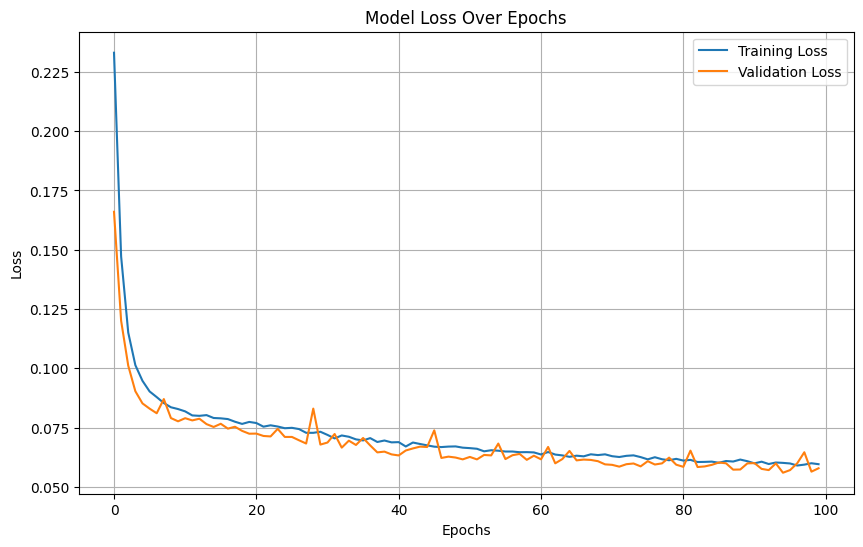

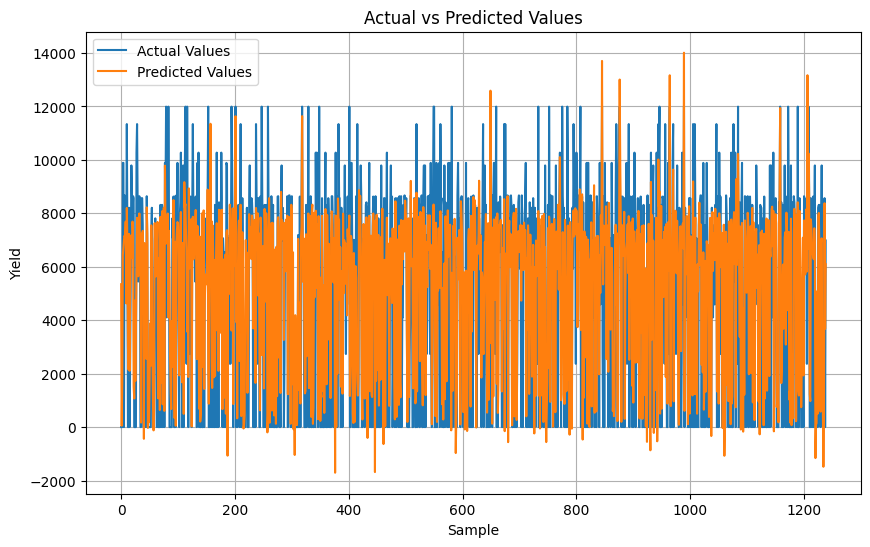

In [8]:
import matplotlib.pyplot as plt

# 1. Training Loss 시각화 (훈련 과정에서의 손실 값)
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. 실제 값과 예측 값을 비교하는 시각화
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Sample')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True)
    plt.show()

# 훈련 과정 손실 시각화
plot_training_history(history)

# 실제 값과 예측 값 시각화 (스케일 역변환 후)
plot_predictions(scaler_y.inverse_transform(y_test), y_pred)


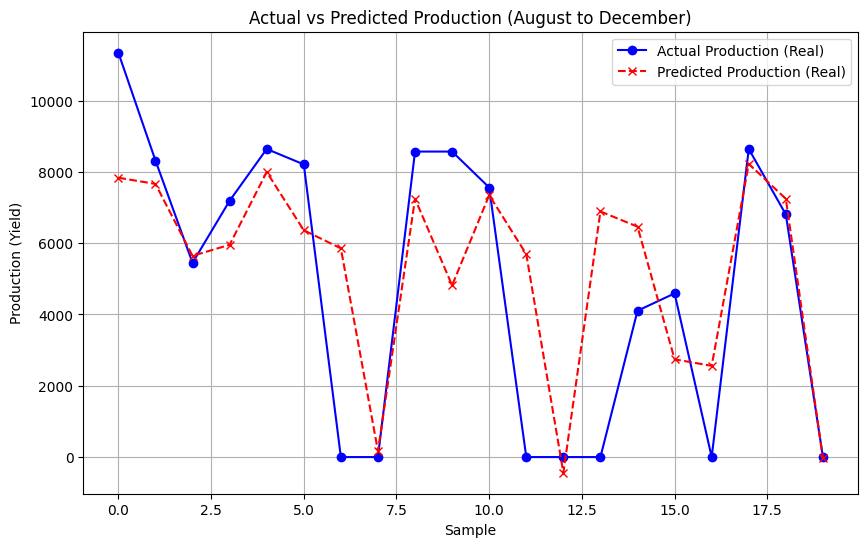

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 꺾은선 그래프로 8월부터 12월까지의 실제 생산량과 예측 생산량 비교
def plot_real_production_aug_to_dec(y_test_scaled, y_pred_scaled, scaler_y):
    # y_test와 y_pred를 원래 값으로 역변환
    y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
    y_pred_actual = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # 8월부터 12월까지의 기간 (임의로 8월~12월까지의 인덱스 범위를 설정)
    start_index = 7 * 4  # 예: 7월 이후 4주차부터 시작
    end_index = 12 * 4  # 예: 12월 말까지

    # 해당 기간 데이터만 슬라이싱
    y_test_filtered = y_test_actual[start_index:end_index]
    y_pred_filtered = y_pred_actual[start_index:end_index]

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_filtered, label='Actual Production (Real)', color='blue', linestyle='-', marker='o')
    plt.plot(y_pred_filtered, label='Predicted Production (Real)', color='red', linestyle='--', marker='x')
    plt.title('Actual vs Predicted Production (August to December)')
    plt.xlabel('Sample')
    plt.ylabel('Production (Yield)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 8월부터 12월까지 시각화
plot_real_production_aug_to_dec(y_test, y_pred_scaled, scaler_y)
